In [1]:
%cd "../"
%pwd


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import math 
import random
from pred_score import *
from load_data import read_memory_genes

C:\Users\alexi\Desktop\Memory_genes\src


In [2]:
#Fixing seed to get reproducible results
random.seed(3)
np.random.seed(3)

# Get memory genes 

In [6]:
names = ['CD8', 'L1210', 'LK_D2_exp1_library_d2_1', 'LK_D2_exp1_library_d2_2', 'LK_D2_exp1_library_d2_3', 'LK_LSK_D2_exp3_library_d2_1', 'LK_LSK_D2_exp3_library_d2_2', 'LK_LSK_D2_exp3_library_d2_3', 'LK_LSK_D2_exp3_library_d2_4', 'LK_LSK_D2_exp3_library_d2_5', 'LSK_D2_exp1_library_LSK_d2_1', 'LSK_D2_exp1_library_LSK_d2_2', 'LSK_D2_exp1_library_LSK_d2_3', 'LSK_D2_exp2_library_d2A_1', 'LSK_D2_exp2_library_d2A_2', 'LSK_D2_exp2_library_d2A_3' , 'LSK_D2_exp2_library_d2A_4', 'LSK_D2_exp2_library_d2A_5', 'LSK_D2_exp2_library_d2B_1','LSK_D2_exp2_library_d2B_2', 'LSK_D2_exp2_library_d2B_3', 'LSK_D2_exp2_library_d2B_4', 'LSK_D2_exp2_library_d2B_5', 
         'LK_LSK_D2_exp3_library_d2_1', 'LK_LSK_D2_exp3_library_d2_2','LK_LSK_D2_exp3_library_d2_3', 'LK_LSK_D2_exp3_library_d2_4', 'LK_LSK_D2_exp3_library_d2_5']

for name in names:
    memory_genes = read_memory_genes('../data/data_master/P_value_estimate_CV2_ofmeans_' + name + '.txt')
    pd.DataFrame(memory_genes).to_csv('../data/CV2genes/' + name + '_CV2mean.csv')

# Investigate overlap between sets

In [53]:
gene_1 = list(np.squeeze(pd.read_csv ('../data/optimized_subsets/D0genes_best.csv')))
gene_2 = list(np.squeeze(pd.read_csv ('../data/optimized_subsets/D6genes_best.csv')))
gene_3 = list(np.squeeze(pd.read_csv ('../data/optimized_subsets/D15genes_best.csv')))
gene_4 = list(np.squeeze(pd.read_csv ('../data/optimized_subsets/AE4genes_best.csv')))
gene_5 = list(np.squeeze(pd.read_csv ('../data/optimized_subsets/AE4_MEFgenes_best.csv')))

print(len(gene_1), len(gene_4), len(gene_5))

1070 251 850


In [56]:
gene_1 = list(np.squeeze(pd.read_csv ('../data/optimized_subsets/AE3genes_best.csv')))
gene_2 = list(np.squeeze(pd.read_csv ('../data/optimized_subsets/LKgenes_best.csv')))
gene_3 = list(np.squeeze(pd.read_csv ('../data/optimized_subsets/AE3_LKgenes_best.csv')))

print(len(gene_1), len(gene_2), len(gene_3))

1309 1280 500


In [60]:
overlap = set(gene_2).intersection(gene_3).intersection(gene_1)
len(overlap)

15

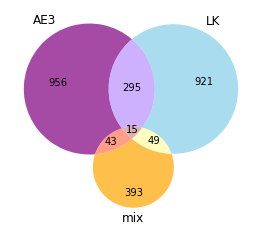

In [75]:
from matplotlib_venn import venn2, venn3

venn3(subsets = (956, 921, 295, 393, 43, 49, 15), set_labels = ('AE3', 'LK', 'mix'), set_colors=('purple', 'skyblue', 'orange'), alpha = 0.7)

# AE3

In [4]:
#Load preprocess data
AE3 = pd.read_csv ('../data/merged_data/AE3.csv')
AE3 = AE3.set_index('Unnamed: 0')
y = np.squeeze(np.array(pd.read_csv ('../data/merged_data/y_AE3.csv')))

AE3.shape

(32285, 333)

 ### Baseline (with all genes)

In [4]:
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(np.array(AE3),y)
print(model.score_, model.recovery)

0.3508771929824561 0.6396396396396397


### Baseline (random)

In [5]:
AE3_shuffle =  np.array(pd.DataFrame(AE3).sample(frac = 1))
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE3_shuffle,y)
print(model.score_, model.recovery)

0.0 0.6396396396396397


### Optimized subset (MIM)

In [5]:
genes_AE3 = np.squeeze(pd.read_csv ('../data/processed_data/AE3genes_interest.csv'))
gene_optimized = np.squeeze(pd.read_csv ('../data/optimized_subsets/AE3CV2mean.csv'))

'''ind_opt_genes = []
for gene in gene_optimized:
    ind_opt_genes = np.append(ind_opt_genes, int(np.squeeze(np.where(genes_AE3 == gene))))
ind_opt_genes= list(ind_opt_genes.astype(int))

#Only keep the optimized genes
AE3 = AE3[:,ind_opt_genes]
print(AE3.shape)'''

AE3 = np.array(AE3.loc[gene_optimized]).T

subset = np.ones((len(gene_optimized),))
subsets = subsampling_genes(subset, 101, 0.25)
print(len(subsets[0]))

AE3.shape

4820


(333, 4820)

In [6]:
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE3,y)
print(model.score_, model.recovery)

compute_sensitivity(y, pred)

0.5935828877005348 0.7177177177177178


In [7]:
model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = AE3, y= y)
print(model.score_, model.recovery)

KeyboardInterrupt: 

In [5]:
def plot_cutoff(x:np.array, y:np.array, all_genes:np.array, best_genes:np.array, name_data:str):
    cut_off = np.linspace(0.1,1,10)
    
    precision, recovery = [], []
    precision_base, recovery_base = [], []
    
    #With all genes
    subset = np.ones((x.shape[1],))
    subsets = subsampling_genes(subset, 101, 0.25)
    for t in cut_off:
        model = EnsemblingHierarchical(np.unique(y),compute_precision,True, subsets = subsets, ensembling='voting', threshold_voting = t)
        result  = model.fit_predict(X = x, y= y)
        precision_base.append(model.score_) 
        recovery_base.append(model.recovery)
    
    #With the optimized gene set
    ind_opt_genes = []
    for gene in gene_optimized:
        ind = np.squeeze(np.where(all_genes == gene))
        
        if ind.shape == (2,):
            continue
        ind_opt_genes = np.append(ind_opt_genes, ind)
        ind_opt_genes= list(ind_opt_genes.astype(int))

    #Only keep the optimized genes
    x = x[:,ind_opt_genes]
    
    subset = np.ones((x.shape[1],))
    subsets = subsampling_genes(subset, 101, 0.25)
    
    for t in cut_off:
        model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = t)
        result  = model.fit_predict(X = x, y= y)
        precision.append(model.score_) 
        recovery.append(model.recovery)
    
    #Plot the precision
    fig,ax = plt.subplots()
    # make a plot
    ax.plot(cut_off, precision, color="red", marker='o')
    ax.plot(cut_off, precision_base, color="blue", marker='o')
    # set x-axis label
    ax.set_xlabel("cut off")
    # set y-axis label
    ax.set_ylabel("precision")

    # twin object for two different y-axis on the sample plot
    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(cut_off, recovery, color="red", marker='o')
    #ax2.plot(cut_off, precision_random, color="yellow")
    ax2.plot(cut_off, recovery_base, color="blue", marker='o')
    ax2.set_ylabel("recovery")
    plt.show()
    
    #Save results in a table
    d = {'precision_ base': precision_base, 'recovery_base': recovery_base, 'precision_repeated' : precision, 'recovery_repeated': recovery}
    results = pd.DataFrame(data = d, index = cut_off)
    
    results.to_csv('../data/prediction_results/' + name_data + '_results.csv', index=True)
        

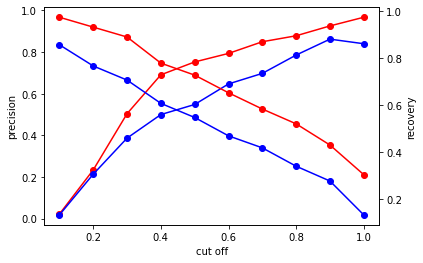

In [13]:
genes_AE3 = np.squeeze(pd.read_csv ('../data/processed_data/AE3genes_interest.csv'))
gene_optimized = np.squeeze(pd.read_csv ('../data/optimized_subsets/AE3genes_bestMIM.csv'))
plot_cutoff(x=AE3, y=y, all_genes= genes_AE3, best_genes=gene_optimized, name_data='AE3')

# AE4

In [14]:
#Load preprocess data
AE4 = np.array(pd.read_csv ('../data/processed_data/AE4.csv'))
y = np.array(AE4[:,-1],dtype=int)
AE4 = AE4[:,0:-1]
AE4.shape

(1473, 9870)

 ### Baseline (with all genes)

In [6]:
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE4,y)
print(model.score_, model.recovery)

0.028664495114006514 0.9280380176510523


### Baseline (random)

In [ ]:
AE4_shuffle =  np.array(pd.DataFrame(AE4).sample(frac = 1))
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE4_shuffle,y)
print(model.score_, model.recovery)

### Optimized subset (ANOVA)

In [ ]:
genes_AE4 = np.squeeze(pd.read_csv ('../data/processed_data/AE4genes_interest.csv'))
gene_optimized = np.squeeze(pd.read_csv ('../data/optimized_subsets/AE4genes_bestANOVA.csv'))

ind_opt_genes = []
for gene in gene_optimized:
    ind_opt_genes = np.append(ind_opt_genes, int(np.squeeze(np.where(genes_AE4 == gene))))
ind_opt_genes= list(ind_opt_genes.astype(int))

#Only keep the optimized genes
AE4 = AE4[:,ind_opt_genes]
print(AE4.shape)

subset = np.ones((len(gene_optimized),))
subsets = subsampling_genes(subset, 101, 0.25)
print(len(subsets[0]))

In [ ]:
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE4,y)
print(model.score_, model.recovery)

In [ ]:
model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = AE4, y= y)
print(model.score_, model.recovery)

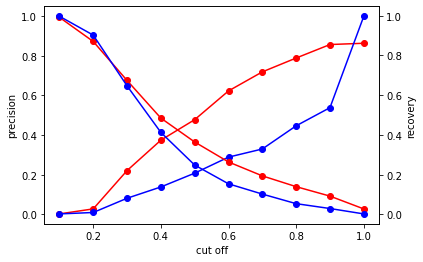

In [15]:
genes_AE4 = np.squeeze(pd.read_csv ('../data/processed_data/AE4genes_interest.csv'))
gene_optimized = np.squeeze(pd.read_csv ('../data/optimized_subsets/AE4genes_bestANOVA.csv'))
plot_cutoff(x=AE4, y=y, all_genes= genes_AE4, best_genes=gene_optimized,name_data='AE4')

# AE7

In [ ]:
#Load preprocess data
AE7 = np.array(pd.read_csv ('../data/processed_data/AE7.csv'))
y = np.array(AE7[:,-1],dtype=int)
AE7 = AE7[:,0:-1]
AE7.shape

 ### Baseline (with all genes)

In [ ]:
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE7,y)
print(model.score_, model.recovery)

### Baseline (random)

In [ ]:
AE7_shuffle =  np.array(pd.DataFrame(AE7).sample(frac = 1))
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE7_shuffle,y)
print(model.score_, model.recovery)

### Optimized subset (ANOVA)

In [ ]:
genes_AE7 = np.squeeze(pd.read_csv ('../data/processed_data/AE7genes_interest.csv'))
gene_optimized = np.squeeze(pd.read_csv ('../data/optimized_subsets/AE7genes_bestMIM.csv'))

ind_opt_genes = []
for gene in gene_optimized:
    ind_opt_genes = np.append(ind_opt_genes, int(np.squeeze(np.where(genes_AE7 == gene))))
ind_opt_genes= list(ind_opt_genes.astype(int))

#Only keep the optimized genes
AE7 = AE7[:,ind_opt_genes]
print(AE7.shape)

subset = np.ones((len(gene_optimized),))
subsets = subsampling_genes(subset, 101, 0.25)
print(len(subsets[0]))

In [ ]:
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(AE7,y)
print(model.score_, model.recovery)

In [ ]:
model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = AE7, y= y)
print(model.score_, model.recovery)

# DO

In [16]:
#Load preprocess data
D0 = np.array(pd.read_csv ('../data/processed_data/D0.csv'))
y = np.array(D0[:,-1],dtype=int)
D0 = D0[:,0:-1]
D0.shape

(461, 10310)

 ### Baseline (with all genes)

In [11]:
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(D0,y)
print(model.score_, model.recovery)

0.6686746987951807 0.720173535791757


### Baseline (random)

In [12]:
D0_shuffle =  np.array(pd.DataFrame(D0).sample(frac = 1))
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(D0_shuffle,y)
print(model.score_, model.recovery)

0.0 0.720173535791757


### Optimized subset (MIM)

In [13]:
genes_D0 = np.squeeze(pd.read_csv ('../data/processed_data/D0genes_interest.csv'))
gene_optimized = np.squeeze(pd.read_csv ('../data/optimized_subsets/D0genes_bestMIM.csv'))

ind_opt_genes = []
for gene in gene_optimized:
    ind_opt_genes = np.append(ind_opt_genes, int(np.squeeze(np.where(genes_D0 == gene))))
ind_opt_genes= list(ind_opt_genes.astype(int))

#Only keep the optimized genes
D0 = D0[:,ind_opt_genes]
print(D0.shape)

subset = np.ones((len(gene_optimized),))
subsets = subsampling_genes(subset, 101, 0.25)
print(len(subsets[0]))

(461, 2480)
2480


In [14]:
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(D0,y)
print(model.score_, model.recovery)

0.9444444444444444 0.8590021691973969


In [15]:
model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = D0, y = y)
print(model.score_, model.recovery)

(101, 461)
0.9680851063829787 0.8156182212581344


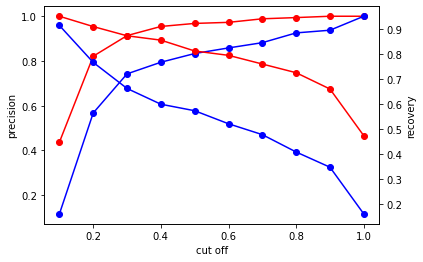

In [17]:
genes_D0 = np.squeeze(pd.read_csv ('../data/processed_data/D0genes_interest.csv'))
gene_optimized = np.squeeze(pd.read_csv ('../data/optimized_subsets/D0genes_bestMIM.csv'))
plot_cutoff(x=D0, y=y, all_genes= genes_D0, best_genes=gene_optimized,name_data='D0')

# D6

In [18]:
#Load preprocess data
D6 = np.array(pd.read_csv ('../data/processed_data/D6.csv'))
y = np.array(D6[:,-1],dtype=int)
D6 = D6[:,0:-1]
D6.shape

(154, 10372)

 ### Baseline (with all genes)

In [17]:
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(D6,y)
print(model.score_, model.recovery)

0.5961538461538461 0.6753246753246753


### Baseline (random)

In [18]:
D6_shuffle =  np.array(pd.DataFrame(D6).sample(frac = 1))
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(D6_shuffle,y)
print(model.score_, model.recovery)

0.038461538461538464 0.6753246753246753


### Optimized subset (ANOVA)

In [19]:
genes_D6 = np.squeeze(pd.read_csv ('../data/processed_data/D6genes_interest.csv'))
gene_optimized = np.squeeze(pd.read_csv ('../data/optimized_subsets/D6genes_bestANOVA.csv'))

ind_opt_genes = []
for gene in gene_optimized:
    ind_opt_genes = np.append(ind_opt_genes, int(np.squeeze(np.where(genes_D6 == gene))))
ind_opt_genes= list(ind_opt_genes.astype(int))

#Only keep the optimized genes
D6 = D6[:,ind_opt_genes]
print(D6.shape)

subset = np.ones((len(gene_optimized),))
subsets = subsampling_genes(subset, 101, 0.25)
print(len(subsets[0]))

(154, 830)
830


In [20]:
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(D6,y)
print(model.score_, model.recovery)

0.9552238805970149 0.8701298701298701


In [21]:
model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = D6, y = y)
print(model.score_, model.recovery)

(101, 154)
0.953125 0.8311688311688312


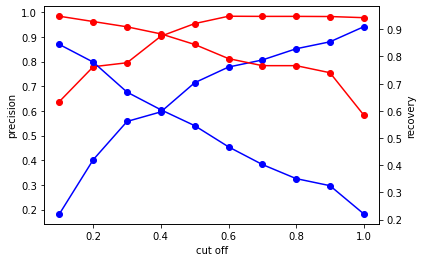

In [19]:
genes_D6 = np.squeeze(pd.read_csv ('../data/processed_data/D6genes_interest.csv'))
gene_optimized = np.squeeze(pd.read_csv ('../data/optimized_subsets/D6genes_bestANOVA.csv'))
plot_cutoff(x=D6, y=y, all_genes= genes_D6, best_genes=gene_optimized,name_data='D6')

# D15

In [20]:
#Load preprocess data
D15 = np.array(pd.read_csv ('../data/processed_data/D15.csv'))
y = np.array(D15[:,-1],dtype=int)
D15 = D15[:,0:-1]
D15.shape

(178, 9977)

 ### Baseline (with all genes)

In [23]:
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(D15,y)
print(model.score_, model.recovery)

0.8714285714285714 0.7865168539325843


### Baseline (random)

In [24]:
D15_shuffle =  np.array(pd.DataFrame(D15).sample(frac = 1))
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(D15_shuffle,y)
print(model.score_, model.recovery)

0.014285714285714285 0.7865168539325843


### Optimized subset (ANOVA)

In [25]:
genes_D15 = np.squeeze(pd.read_csv ('../data/processed_data/D15genes_interest.csv'))
gene_optimized = np.squeeze(pd.read_csv ('../data/optimized_subsets/D15genes_bestANOVA.csv'))

ind_opt_genes = []
for gene in gene_optimized:
    ind_opt_genes = np.append(ind_opt_genes, int(np.squeeze(np.where(genes_D15 == gene))))
ind_opt_genes= list(ind_opt_genes.astype(int))

#Only keep the optimized genes
D15 = D15[:,ind_opt_genes]
print(D15.shape)

subset = np.ones((len(gene_optimized),))
subsets = subsampling_genes(subset, 101, 0.25)
print(len(subsets[0]))

(178, 110)
110


In [26]:
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(D15,y)
print(model.score_, model.recovery)

1.0 0.9775280898876404


In [27]:
model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = D15, y = y)
print(model.score_, model.recovery)

(101, 178)
1.0 0.9775280898876404


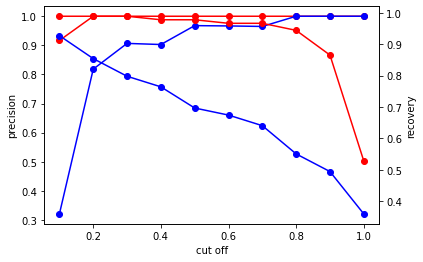

In [21]:
genes_D15 = np.squeeze(pd.read_csv ('../data/processed_data/D15genes_interest.csv'))
gene_optimized = np.squeeze(pd.read_csv ('../data/optimized_subsets/D15genes_bestANOVA.csv'))
plot_cutoff(x=D15, y=y, all_genes= genes_D15, best_genes=gene_optimized, name_data='D15')

# LK

In [11]:
#Load preprocess data
LK = np.array(pd.read_csv ('../data/processed_data/LK.csv'))
y = np.array(LK[:,-1],dtype=int)
LK = LK[:,0:-1]
LK.shape

(610, 8405)

 ### Baseline (with all genes)

In [29]:
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(LK,y)
print(model.score_, model.recovery)

0.20603015075376885 0.8131147540983606


### Baseline (random)

In [30]:
LK_shuffle =  np.array(pd.DataFrame(LK).sample(frac = 1))
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(LK_shuffle,y)
print(model.score_, model.recovery)

0.0 0.8131147540983606


### Optimized subset (MIM)

In [3]:
genes_LK = np.squeeze(pd.read_csv ('../data/processed_data/LKgenes_interest.csv'))
gene_optimized = np.squeeze(pd.read_csv ('../data/optimized_subsets/LKgenes_bestMIM.csv'))

ind_opt_genes = []
for gene in gene_optimized:
    ind = np.squeeze(np.where(genes_LK == gene))
    if ind.shape == ():
        ind_opt_genes = np.append(ind_opt_genes, int(ind))
    else:
        for i in ind:
                ind_opt_genes = np.append(ind_opt_genes, int(i))
            
ind_opt_genes= list(ind_opt_genes.astype(int))

#Only keep the optimized genes
LK = LK[:,ind_opt_genes]
print(LK.shape)

subset = np.ones((LK.shape[1],))
subsets = subsampling_genes(subset, 101, 0.25)
print(len(subsets[0]))

NameError: name 'LK' is not defined

In [77]:
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(LK,y)
print(model.score_, model.recovery)

0.40173410404624277 0.7016393442622951


In [78]:
model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = LK, y = y)
print(model.score_, model.recovery)

(101, 610)
0.6255924170616114 0.4737704918032787


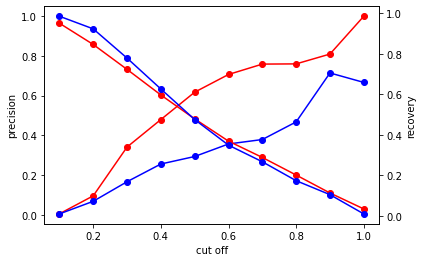

In [12]:
genes_LK = np.squeeze(pd.read_csv ('../data/processed_data/LKgenes_interest.csv'))
gene_optimized = np.squeeze(pd.read_csv ('../data/optimized_subsets/LKgenes_bestMIM.csv'))

non_unique = np.squeeze(pd.read_csv('../data/non_unique_genes.csv'))
for gene in non_unique:
    if gene in gene_optimized:
        gene_optimized.remove(gene)

plot_cutoff(x=LK, y=y, all_genes= genes_LK, best_genes=gene_optimized, name_data='LK')

### Prediction by barcode library

In [7]:
lib = [0,1,2,3,4,5,6,7,8]
for i in lib:
    
    print('-------------------------')
    print('Barcode library ' + str(i))
    LK = pd.read_csv ('../data/processed_data/LKlib' + str(i) + '.csv')
    LK = np.array(LK.set_index('Unnamed: 0')).T
    y_LK  = np.squeeze(np.array(pd.read_csv('../data/processed_data/y_LK_lib' + str(i) + '.csv')))
    genes_LK = np.squeeze(pd.read_csv ('../data/processed_data/LKfusedlibraries_genes_interest.csv'))
    gene_optimized = np.squeeze(pd.read_csv ('../data/optimized_subsets/LKgenes_bestMIM.csv'))

    ind_opt_genes = []
    for gene in gene_optimized:
        ind = np.squeeze(np.where(genes_LK == gene))
        if ind.shape == ():
            ind_opt_genes = np.append(ind_opt_genes, int(ind))
        else:
            for i in ind:
                    ind_opt_genes = np.append(ind_opt_genes, int(i))

    ind_opt_genes= list(ind_opt_genes.astype(int))
    print(len(ind_opt_genes))

    #Only keep the optimized genes
    LK = LK[:,ind_opt_genes]
    print(LK.shape)

    subset = np.ones((LK.shape[1],))
    subsets = subsampling_genes(subset, 101, 0.25)
    
    #Predict once
    model = FamiliesClusters(np.unique(y_LK),compute_precision,True)
    pred = model.fit_predict(LK,y_LK)
    print(model.score_, model.recovery)
    
    #Predict repetitively
    model = EnsemblingHierarchical(np.unique(y_LK),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
    result  = model.fit_predict(X = LK, y = y_LK)
    print(model.score_, model.recovery)

-------------------------
Barcode library 0
777
(117, 777)
0.047619047619047616 0.717948717948718
0.09090909090909091 0.18803418803418803
-------------------------
Barcode library 1
777
(194, 777)
0.01282051282051282 0.8041237113402062
0.0 0.1134020618556701
-------------------------
Barcode library 2
777
(244, 777)
0.03333333333333333 0.7377049180327869
0.1111111111111111 0.07377049180327869
-------------------------
Barcode library 3
777
(194, 777)
0.01282051282051282 0.8041237113402062
0.0 0.1134020618556701
-------------------------
Barcode library 4
777
(6, 777)
0.0 0.3333333333333333
0.0 0.3333333333333333
-------------------------
Barcode library 5
777
(2, 777)
0 1.0
0 1.0
-------------------------
Barcode library 6
777
(10, 777)
0.0 0.8
0.0 0.8
-------------------------
Barcode library 7
777
(22, 777)
0.0 0.7727272727272727
0.0 0.5454545454545454
-------------------------
Barcode library 8
777
(13, 777)
0.4 0.7692307692307693
0.3333333333333333 0.46153846153846156


# LSK

In [13]:
#Load preprocess data
LSK = np.array(pd.read_csv ('../data/processed_data/LSK.csv'))
y = np.array(LSK[:,-1],dtype=int)
LSK = LSK[:,0:-1]
LSK.shape

(3383, 7570)

 ### Baseline (with all genes)

In [80]:
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(LSK,y)
print(model.score_, model.recovery)

0.08357588357588358 0.9269878805793674


### Baseline (random)

In [81]:
LSK_shuffle =  np.array(pd.DataFrame(LSK).sample(frac = 1))
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(LSK_shuffle,y)
print(model.score_, model.recovery)

0.0008316008316008316 0.9269878805793674


### Optimized subset (ANOVA)

In [88]:
genes_LSK = np.squeeze(pd.read_csv ('../data/processed_data/LSKgenes_interest.csv'))
gene_optimized = np.squeeze(pd.read_csv ('../data/optimized_subsets/LSKgenes_bestANOVA.csv'))

ind_opt_genes = []
for gene in gene_optimized:
    ind = np.squeeze(np.where(genes_LSK == gene))
    if ind.shape == ():
        ind_opt_genes = np.append(ind_opt_genes, int(ind))
    else:
        for i in ind:
                ind_opt_genes = np.append(ind_opt_genes, int(i))
ind_opt_genes= list(ind_opt_genes.astype(int))

#Only keep the optimized genes
LSK = LSK[:,ind_opt_genes]
print(LSK.shape)

subset = np.ones((LSK.shape[1],))
subsets = subsampling_genes(subset, 101, 0.25)
print(len(subsets[0]))

(3383, 418)
418


In [89]:
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(LSK,y)
print(model.score_, model.recovery)

0.15286041189931351 0.8288501330180313


In [ ]:
model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = LSK, y = y)
print(model.score_, model.recovery)

(101, 3383)
0.42971887550200805 0.23558971327224357


In [ ]:
genes_LSK = np.squeeze(pd.read_csv ('../data/processed_data/LSKgenes_interest.csv'))
gene_optimized = list(np.squeeze(pd.read_csv ('../data/optimized_subsets/LSKgenes_bestANOVA.csv')))
non_unique = np.squeeze(pd.read_csv('../data/non_unique_genes.csv'))
for gene in non_unique:
    if gene in gene_optimized:
        gene_optimized.remove(gene)

plot_cutoff(x=LSK, y=y, all_genes= genes_LSK, best_genes=gene_optimized, name_data='LSK')

### Prediction by barcode library

In [9]:
ind_dataset = np.squeeze(np.array(pd.read_csv('../data/processed_data/size_librariesLSK.csv')))
#Load preprocess data
LSK = np.array(pd.read_csv ('../data/processed_data/LSKfusedlibrary.csv'))
y = np.array(LSK[:,-1],dtype=int)
LSK = LSK[:,0:-1]

for i in range(len(ind_dataset)):
    x_train, y_train, x_test, y_test = getTrainTestAll(y, LK, ind_dataset, i)
    
    genes_LSK = np.squeeze(pd.read_csv ('../data/processed_data/LSKfusedlibraries_genes_interest.csv'))
    gene_optimized = np.squeeze(pd.read_csv ('../data/optimized_subsets/LSKgenes_bestANOVA.csv'))

    ind_opt_genes = []
    for gene in gene_optimized:
        ind = np.squeeze(np.where(genes_LSK == gene))
        if ind.shape == ():
            ind_opt_genes = np.append(ind_opt_genes, int(ind))
        else:
            for i in ind:
                    ind_opt_genes = np.append(ind_opt_genes, int(i))

    ind_opt_genes= list(ind_opt_genes.astype(int))
    
    x_test= x_test[:,ind_opt_genes]
    
    model = FamiliesClusters(np.unique(y_test),compute_precision,True)
    pred = model.fit_predict(x_test,y_test)
    print(model.score_, model.recovery)
    
    #Predict repetitively
    model = EnsemblingHierarchical(np.unique(y_test),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
    result  = model.fit_predict(X = x_test, y = y_test)
    print(model.score_, model.recovery)

IndexError: index 13 is out of bounds for axis 0 with size 13

# LK/LSK mix

In [ ]:
#Load preprocess data
LSKmix = np.array(pd.read_csv ('../data/processed_data/LSKmix.csv'))
y = np.array(LSKmix[:,-1],dtype=int)
LSKmix = LSKmix[:,0:-1]
LSKmix.shape

 ### Baseline (with all genes)

In [92]:
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(LSKmix,y)
print(model.score_, model.recovery)

0.13649425287356323 0.8651026392961877


### Baseline (random)

In [93]:
LSKmix_shuffle =  np.array(pd.DataFrame(LSKmix).sample(frac = 1))
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(LSKmix_shuffle,y)
print(model.score_, model.recovery)

0.0028735632183908046 0.8651026392961877


### Optimized subset (ANOVA)

In [99]:
genes_LSKmix = np.squeeze(pd.read_csv ('../data/processed_data/LSKmixgenes_interest.csv'))
gene_optimized = np.squeeze(pd.read_csv ('../data/optimized_subsets/LSKmixgenes_bestANOVA.csv'))

ind_opt_genes = []
for gene in gene_optimized:
    ind = np.squeeze(np.where(genes_LSKmix == gene))
    if ind.shape == ():
        ind_opt_genes = np.append(ind_opt_genes, int(ind))
    else:
        for i in ind:
                ind_opt_genes = np.append(ind_opt_genes, int(i))
ind_opt_genes= list(ind_opt_genes.astype(int))

#Only keep the optimized genes
LSKmix = LSKmix[:,ind_opt_genes]
print(LSKmix.shape)

subset = np.ones((LSKmix.shape[1],))
subsets = subsampling_genes(subset, 101, 0.25)
print(len(subsets[0]))

(1023, 294)
294


In [100]:
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(LSKmix,y)
print(model.score_, model.recovery)

0.2084507042253521 0.8807429130009775


In [101]:
model = EnsemblingHierarchical(np.unique(y),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
result  = model.fit_predict(X = LSKmix, y = y)
print(model.score_, model.recovery)

(101, 1023)
0.4703196347031963 0.32942326490713586


In [ ]:
genes_LSKmix = np.squeeze(pd.read_csv ('../data/processed_data/LSKmixgenes_interest.csv'))
gene_optimized = np.squeeze(pd.read_csv ('../data/optimized_subsets/LSKmixgenes_bestANOVA.csv'))
non_unique = np.squeeze(pd.read_csv('../data/non_unique_genes.csv'))
for gene in non_unique:
    if gene in gene_optimized:
        gene_optimized.remove(gene)
plot_cutoff(x=LSKmix, y=y, all_genes= genes_LSKmix, best_genes=gene_optimized,name_data='LSKmix')

### Prediction by barcode library

In [10]:
ind_dataset = np.squeeze(np.array(pd.read_csv('../data/processed_data/size_librariesLSKmix.csv')))
#Load preprocess data
LSK = np.array(pd.read_csv ('../data/processed_data/LSKmixfusedlibrary.csv'))
y = np.array(LSK[:,-1],dtype=int)
LSK = LSK[:,0:-1]

for i in range(len(ind_dataset)):
    x_train, y_train, x_test, y_test = getTrainTestAll(y, LK, ind_dataset, i)
    
    genes_LSK = np.squeeze(pd.read_csv ('../data/processed_data/LSKmixfusedlibraries_genes_interest.csv'))
    gene_optimized = np.squeeze(pd.read_csv ('../data/optimized_subsets/LSKmixgenes_bestANOVA.csv'))

    ind_opt_genes = []
    for gene in gene_optimized:
        ind = np.squeeze(np.where(genes_LSK == gene))
        if ind.shape == ():
            ind_opt_genes = np.append(ind_opt_genes, int(ind))
        else:
            for i in ind:
                    ind_opt_genes = np.append(ind_opt_genes, int(i))

    ind_opt_genes= list(ind_opt_genes.astype(int))
    
    x_test= x_test[:,ind_opt_genes]
    
    model = FamiliesClusters(np.unique(y_test),compute_precision,True)
    pred = model.fit_predict(x_test,y_test)
    print(model.score_, model.recovery)
    
    #Predict repetitively
    model = EnsemblingHierarchical(np.unique(y_test),compute_precision,True,subsets = subsets, ensembling='voting', threshold_voting = 0.5)
    result  = model.fit_predict(X = x_test, y = y_test)
    print(model.score_, model.recovery)

IndexError: index 13 is out of bounds for axis 0 with size 13